# waypoints

## define agents

In [1]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [2]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"../maps/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='Oschersleben1')

## create waypoints

In [10]:

done = False
env = WPEnv(map_name='race2', begin_pos=[0.0702245, 0.3002981, 2.79787])
obs = env.reset()
agent = FGAgent(speed=3.0, bubble_r=0.5)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [11]:
with open('../maps/race2-wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [9]:
import numpy as np

with open('../maps/phy6-wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[32][:2])
print(dist)
print(len(wps))
print(len(wps)//70)

0.40318595272794694
2698
38


In [8]:
from tqdm import tqdm
import gym

map_name = 'race1'
env = gym.make('f110_gym:f110-v0', map=f"../maps/{map_name}", map_ext='.png', num_agents=1)
cnt = 0
for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.4:
        cnt += 1
print(cnt)

100%|██████████| 8658/8658 [00:03<00:00, 2251.99it/s]

43


In [27]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

12948

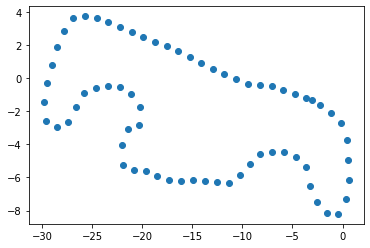

In [10]:
import matplotlib.pyplot as plt
wps =wps[::40]
plt.scatter(wps[:,0], wps[:, 1])

# environment

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=7.0,
                 n_cps = 70,
                 cp_reward = 0.2,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='phy',
                 padding_punish=-0.05,
                 safe_padding=0.4,
                 laps = 1.0,
                 min_deg=80,
                 max_deg=280,
                 begin_pos=[-3.0702245, -2.3002981, 2.79787]
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(202,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [1.0] * 100
        self.padding_punish = padding_punish
        
        self.total_padding_punish = 0
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.begin_pos = begin_pos
        self.ang_vel_diff_hist = [0.0]*50
        self.prev_ang_vel = 0.0
        self.oscilation_cum_rew = 0
        self.prev_cp_t = 0
        
        self.cp_prev_vel = []
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

    def load_train_setup(self):
        no = np.random.choice([1,2,3,4,5,6])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/{self.train_map_name}{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/{self.train_map_name}1-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.oscilation_cum_rew = 0
        self.prev_vel = [1.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        self.cp_prev_vel = [0.0,]
        self.ang_vel_diff_hist = [0.0,]
        self.prev_ang_vel = 0.0
        self.prev_cp_t = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            rotate = np.random.choice([0, np.pi])
            if rotate != 0:
                self.checkpoints = self.checkpoints[::-1]
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            start_point[-1] += rotate
            
        else:
            dists = cdist([self.begin_pos[:2]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = self.begin_pos
            
        self.next_cp_idx = (start_idx + 4)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        ## TAKES CARE OF CHECKPOINTS THAT FALL OVER OBSTACLES
        if done:
            return self.reset()
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        ranges = obs['scans'][0]
        ranges = ranges[int((self.min_deg/360)*len(ranges)):int((self.max_deg/360)*len(ranges))]
        scanner = np.clip(ranges, 0, self.scan_range)
        
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
        if self.test_map_name is None:
            noise = np.random.normal(loc=0.0, scale=0.1, size=state.shape)
            state = state + noise
        
        return state
    
    def checkpoint(self, position, t):
        return_cp_idx = (self.next_cp_idx - 10)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
#             time_diff = t - self.prev_cp_t
#             reward = max(self.cp_reward + (0.4 - time_diff)*0.5, self.cp_reward)
            reward = self.cp_reward
            self.prev_cp_t = t
#            print(time_diff)
#             reward = self.cp_reward
#            reward += (np.mean(self.cp_prev_vel)/self.max_v)
#             reward -= np.mean(self.ang_vel_diff_hist)/(np.pi/3)
#            reward *= self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
            self.ang_vel_diff_hist = [0,]
            self.cp_prev_vel = [0,]
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        act_v += np.random.normal(0, 1.0)
        
        #th = action[1]*np.pi/6
        #for real car
        th = action[1]*0.34
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

#         ang_vel_diff = abs(th - self.prev_ang_vel)
#         self.prev_ang_vel = th
#         self.ang_vel_diff_hist.append(ang_vel_diff)
        
#        self.cp_prev_vel.append(act_v)
    
        finish_time = 100
        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            #if self.test_map_name is not None:
            #print('CRASHED')
            return next_state, reward, done, {'finish_time': finish_time}
            
        cp_reward = self.checkpoint(position, obs['lap_times'][0])
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
#           reward = np.exp(2.5 - 0.05*t)
            finish_time = t
#             fairlap = 35
#             reward = max(0.5*(fairlap - t), 0)
            #reward = self.cp_reward
            #print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.mean(self.prev_vel)<1.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += self.padding_punish
            self.total_padding_punish += self.padding_punish
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position, 'finish_time': finish_time,
                                          'oscilation': self.oscilation_cum_rew, 'padding': self.total_padding_punish}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset().shape

(202,)

# training

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [ ]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 12,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
    'num_envs_per_worker': 2,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
#     'horizon': 8000
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
#print("FINE TUNING")
trainer.restore('../checkpoints/phy_v6.0.3/checkpoint_000226/checkpoint-226')

print(trainer.config)
rewards = []
eval_rewards = []
best_time = 1000
models_path = '../checkpoints'
best_reward = -100

import pickle

def evaluate(model, envs):
    avg_r = []
    
    for env in envs:
        done = False
        obs = env.reset()

        r = 0
        while not done:
            action = model.compute_single_action(obs, explore=False)
            obs, reward, done, info = env.step(action)
            r += reward

        avg_r.append(r)
        
    return np.mean(avg_r)


eval_envs = [
    F110RaceEnv({}, test_map_name='phy1', laps=1),
    F110RaceEnv({}, test_map_name='phy2', laps=1),
    F110RaceEnv({}, test_map_name='phy3', laps=1),
    F110RaceEnv({}, test_map_name='phy4', laps=1),
    F110RaceEnv({}, test_map_name='phy5', laps=1),
    F110RaceEnv({}, test_map_name='phy6', laps=1),
]


sim_name = 'phy_v6.1.0'

for i in range(500):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/{sim_name}_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0:
        eval_reward = evaluate(trainer, envs=eval_envs)
        eval_rewards.append(eval_reward)
        with open(f'{models_path}/{sim_name}_er', 'wb') as f:
            pickle.dump(eval_rewards, f)
        if eval_reward > best_reward:
            best_reward = eval_reward
            cp = trainer.save(f"{models_path}/{sim_name}")
            print("checkpoint saved at", cp)


2022-05-23 08:02:29,701	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=12 num_envs_per_worker=2 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 4166.
2022-05-23 08:02:29,702	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-23 08:02:29,703	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=3392) 2022-05-23 08:02:35,179	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=3395) 2022-05-23 08:02:35,289	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorE

{'num_workers': 12, 'num_envs_per_worker': 2, 'create_env_on_driver': False, 'rollout_fragment_length': 4166, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_

(RolloutWorker pid=3385) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy1 got reward 1.7999999999999998 in 1.260000000000001. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 1.2 in 4.199999999999955. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy2 got reward 3.600000000000001 in 2.8799999999999826. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy5 got reward 1.4 in 2.9799999999999804. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy1 got reward 6.550000000000006 in 7.779999999999879. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy2 got reward 10.6 in 12.259999999999783. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy3 got reward 4.5000000000000036 in 7.119999999999893. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy6 got reward 8.000000000000004 in 12.249999999999783. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy5 got reward -0.05 in 0.03. STOPPED
(RolloutWorker pid=3382)

(RolloutWorker pid=3397) agent on ../maps/phy6 got reward 3.600000000000001 in 5.019999999999937. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy4 got reward 14.39999999999998 in 15.029999999999724. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy4 got reward 8.000000000000004 in 11.769999999999794. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy3 got reward 11.199999999999994 in 14.849999999999728. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy2 got reward 4.000000000000001 in 5.169999999999934. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 3.600000000000001 in 6.479999999999906. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 3.600000000000001 in 5.4399999999999284. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy1 got reward 4.000000000000001 in 5.139999999999935. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy3 got reward 9.79999

2022-05-23 08:03:59,219	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


lap: [14.6]
checkpoint saved at ../checkpoints/phy_v6.1.0/checkpoint_000227/checkpoint-227
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 6.400000000000003 in 10.149999999999828. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy1 got reward 10.949999999999987 in 12.659999999999775. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 0.2 in 3.5799999999999677. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy3 got reward 5.8000000000000025 in 5.769999999999921. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy2 got reward 6.450000000000004 in 6.479999999999906. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy5 got reward 10.799999999999994 in 13.509999999999756. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy2 got reward 9.000000000000004 in 9.679999999999838. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy5 got reward 4.200000000000001 in 8.269999999999868. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy6 got reward 11.799

(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 11.549999999999992 in 15.939999999999705. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 11.799999999999986 in 16.279999999999745. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy3 got reward 9.999999999999996 in 13.019999999999767. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy4 got reward 13.199999999999985 in 17.229999999999894. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy4 got reward 3.600000000000001 in 3.4899999999999696. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy1 got reward 10.849999999999994 in 14.669999999999732. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy2 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 8.600000000000001 in 7.469999999999885. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy4 got reward 4.350000000000002 in 9.58999999999984. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy6 got reward 5.4000

(RolloutWorker pid=3397) agent on ../maps/phy5 got reward 5.200000000000002 in 7.959999999999875. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 1.950000000000003 in 4.259999999999954. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy3 got reward 1.2 in 5.82999999999992. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy2 got reward -1.750000000000001 in 5.689999999999923. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 11.84999999999999 in 14.209999999999742. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy5 got reward 2.900000000000001 in 6.959999999999896. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy4 got reward 5.600000000000002 in 7.209999999999891. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy5 got reward 1.0 in 4.709999999999944. STOPPED
(RolloutWorker pid=339

(RolloutWorker pid=3388) agent on ../maps/phy3 got reward 1.550000000000002 in 3.9599999999999596. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy1 got reward 13.149999999999986 in 14.099999999999744. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 3.800000000000001 in 7.809999999999878. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy4 got reward 9.999999999999996 in 9.719999999999837. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy1 got reward 5.8000000000000025 in 7.23999999999989. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 0.4 in 0.8000000000000005. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy6 got reward 7.550000000000007 in 9.819999999999835. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy2 got reward 9.19999999999999 in 14.489999999999736. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy5 got reward 1.0 in 3.5399999999999685. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy5 got reward 0 in 

(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 3.2 in 3.9599999999999596. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy5 got reward 11.049999999999999 in 13.859999999999749. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy1 got reward 4.150000000000002 in 4.749999999999943. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 3.400000000000001 in 2.6999999999999864. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy5 got reward 3.800000000000001 in 7.539999999999884. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy6 got reward 12.599999999999987 in 14.099999999999744. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 3.2000000000000006 in 2.6099999999999883. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 4.450000000000002 in 4.869999999999941. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 5.200000000000002 in 6.089999999999915. RETURNED
(RolloutWorker pid=3386) agent on ../maps/ph

(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 7.200000000000004 in 11.399999999999801. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 8.8 in 8.959999999999853. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy6 got reward -2.8999999999999964 in 6.4699999999999065. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy2 got reward 9.999999999999996 in 13.949999999999747. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy6 got reward 9.550000000000002 in 10.729999999999816. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy3 got reward 3.0000000000000004 in 3.9699999999999593. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy6 got reward 7.800000000000004 in 11.599999999999797. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy2 got reward 1.2 in 4.389999999999951. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy2 got reward 6.600000000000003 in 7.289999999999889. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy2 got reward 8.

(RolloutWorker pid=3388) agent on ../maps/phy5 got reward 2.6 in 1.9200000000000015. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 1.1999999999999993 in 6.199999999999912. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy5 got reward 5.8000000000000025 in 6.7499999999999005. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy5 got reward 6.200000000000003 in 7.2199999999998905. RETURNED
episode: 5 reward:7.898195876288651
lap: [12.97]
lap: [14.27]
lap: [14.05]
lap: [13.94]
lap: [14.52]
lap: [13.67]
checkpoint saved at ../checkpoints/phy_v6.1.0/checkpoint_000232/checkpoint-232
(RolloutWorker pid=3392) agent on ../maps/phy3 got reward 2.8500000000000036 in 4.41999999999995. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 0.2 in 3.179999999999976. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 4.600000000000001 in 4.249999999999954. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy2 got reward 11.59999999999999 in 14.9

(RolloutWorker pid=3399) agent on ../maps/phy2 got reward 13.549999999999985 in 18.510000000000094. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy5 got reward 7.750000000000004 in 14.25999999999974. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 5.000000000000002 in 10.219999999999827. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy6 got reward 7.400000000000007 in 8.859999999999856. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy3 got reward 10.399999999999995 in 12.90999999999977. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy4 got reward 2.4 in 3.2599999999999745. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy2 got reward 6.600000000000003 in 10.01999999999983. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 12.599999999999987 in 16.6399999999998. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 9.0 in 8.509999999999863. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy6 got reward 0.20000

(RolloutWorker pid=3382) agent on ../maps/phy3 got reward 0.8500000000000012 in 8.509999999999863. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 0.2 in 4.009999999999959. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 6.000000000000003 in 7.879999999999876. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy4 got reward 2.1500000000000172 in 13.009999999999767. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy5 got reward 10.799999999999994 in 14.329999999999739. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy1 got reward 3.400000000000001 in 2.6899999999999866. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy4 got reward 4.050000000000001 in 10.389999999999823. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy6 got reward 6.250000000000004 in 9.869999999999834. STOPPED
epi

(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 3.1500000000000004 in 7.71999999999988. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 12.199999999999989 in 12.83999999999977. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy5 got reward 2.1999999999999997 in 1.6200000000000012. RETURNED
episode: 8 reward:8.733967391304338
(RolloutWorker pid=3385) agent on ../maps/phy6 got reward 8.150000000000004 in 8.979999999999853. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy1 got reward 13.599999999999984 in 16.199999999999733. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 8.100000000000005 in 9.399999999999844. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 5.200000000000002 in 7.71999999999988. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy5 got reward 2.4 in 3.5299999999999687. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 0.8 in 4.43999999999995. STOPPED
(RolloutWorker pid=3385) agen

(RolloutWorker pid=3388) agent on ../maps/phy4 got reward 10.899999999999995 in 15.729999999999709. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy1 got reward 2.6 in 5.519999999999927. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy2 got reward 0.8 in 1.450000000000001. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy6 got reward 10.499999999999988 in 13.729999999999752. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 3.0000000000000004 in 6.679999999999902. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy2 got reward 0.8 in 1.480000000000001. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy5 got reward 2.9499999999999997 in 4.87999999999994. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy2 got reward 0 in 3.2999999999999736. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy5 got reward 10.3 in 14.979999999999725. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 8.400000000000002 in 9.59999999999984. RETURNED
(

(RolloutWorker pid=3394) agent on ../maps/phy1 got reward 0 in 2.6599999999999873. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy2 got reward 7.800000000000004 in 8.339999999999867. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 3.600000000000001 in 3.9199999999999604. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 13.599999999999984 in 17.299999999999905. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy3 got reward 2.9000000000000083 in 5.609999999999925. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy3 got reward 9.35 in 10.739999999999815. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy2 got reward 3.400000000000001 in 4.519999999999948. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy3 got reward 5.600000000000002 in 4.799999999999942. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker 

(RolloutWorker pid=3391) agent on ../maps/phy4 got reward 8.100000000000007 in 10.97999999999981. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy2 got reward 11.049999999999994 in 13.31999999999976. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy5 got reward 6.050000000000005 in 6.899999999999897. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 8.000000000000004 in 7.379999999999887. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy1 got reward 10.69999999999999 in 12.019999999999788. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy4 got reward 10.999999999999993 in 11.129999999999807. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy2 got reward 9.599999999999998 in 9.979999999999832. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy6 got reward 4.800000000000004 in 4.539999999999948. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 7.150000000000004 in 10.329999999999824. STOPPED
(RolloutWorker pid=3394) agent on

(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 10.999999999999993 in 14.799999999999729. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy6 got reward 9.549999999999986 in 10.909999999999812. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 8.600000000000001 in 9.58999999999984. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy3 got reward 10.599999999999994 in 14.969999999999725. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 10.549999999999995 in 13.859999999999749. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 1.9499999999999995 in 3.519999999999969. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy2 got reward 4.800000000000002 in 8.849999999999856. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy6 got reward 10.65 in 12.489999999999778. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy2 got reward 0 in 0.02. STOPPE

(RolloutWorker pid=3392) agent on ../maps/phy5 got reward 2.1999999999999997 in 1.8300000000000014. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy5 got reward 1.5999999999999999 in 2.2199999999999966. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy6 got reward 6.100000000000003 in 7.579999999999883. RETURNED
episode: 13 reward:8.965659340659332
(RolloutWorker pid=3388) agent on ../maps/phy2 got reward 0.6000000000000001 in 3.00999999999998. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy4 got reward 1.5999999999999999 in 2.7799999999999847. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy1 got reward 7.800000000000004 in 8.949999999999854. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 0.8 in 5.019999999999937. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy1 got reward 0.2 in 2.769999999999985. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy6 got reward 4.850000000000002 in 8.65999999999986. STOPPED
(RolloutWorker pid=3392) age

(RolloutWorker pid=3385) agent on ../maps/phy4 got reward 9.2 in 12.229999999999784. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy4 got reward 11.199999999999992 in 10.649999999999817. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy2 got reward -5.04999999999999 in 4.509999999999948. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy3 got reward 11.99999999999999 in 11.529999999999799. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy5 got reward 2.1999999999999997 in 1.6300000000000012. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy2 got reward 4.400000000000001 in 7.889999999999876. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy2 got reward 0.4 in 3.1099999999999777. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy5 got reward 9.899999999999999 in 11.779999999999793. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy1 got reward 7.0000000000000036 in 10.269999999999825. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy6 got reward 9.

(RolloutWorker pid=3381) agent on ../maps/phy3 got reward 10.099999999999998 in 14.479999999999736. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy2 got reward 0.2 in 4.329999999999952. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 4.400000000000001 in 5.099999999999936. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy1 got reward 1.2 in 4.2199999999999545. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 12.199999999999989 in 11.829999999999792. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy3 got reward 6.800000000000003 in 9.739999999999837. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 1.9999999999999998 in 1.370000000000001. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy3 got reward 0.8 in 4.589999999999947. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 4.600000000000001 in 9.019999999999852. STOPPED
(R

(RolloutWorker pid=3392) agent on ../maps/phy2 got reward 6.400000000000003 in 6.7899999999999. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy4 got reward 1.5999999999999999 in 2.4999999999999907. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 3.0000000000000004 in 8.369999999999866. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy4 got reward 2.8000000000000003 in 2.5499999999999896. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 3.0000000000000004 in 2.259999999999996. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy6 got reward 4.950000000000002 in 7.039999999999894. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy6 got reward 8.600000000000001 in 11.979999999999789. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy2 got reward 9.0 in 11.859999999999792. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy1 got reward 11.399999999999974 in 11.629999999999797. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy6

(RolloutWorker pid=3394) agent on ../maps/phy1 got reward 2.4 in 1.7300000000000013. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy2 got reward 7.600000000000004 in 8.139999999999871. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 3.0000000000000004 in 3.8699999999999615. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy2 got reward 5.600000000000002 in 5.969999999999917. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy1 got reward 1.7999999999999998 in 4.269999999999953. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy3 got reward 5.5500000000000025 in 7.24999999999989. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy3 got reward 12.44999999999999 in 13.639999999999754. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 8.400000000000002 in 7.279999999999889. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 1.5999999999999999 in 5.869999999999919. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy6 

(RolloutWorker pid=3388) agent on ../maps/phy3 got reward 2.4 in 3.2999999999999736. RETURNED
episode: 19 reward:8.207552083333324
(RolloutWorker pid=3383) agent on ../maps/phy3 got reward 3.0000000000000004 in 6.4699999999999065. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy1 got reward 4.600000000000001 in 5.069999999999936. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy2 got reward 3.400000000000001 in 6.379999999999908. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy1 got reward 7.200000000000004 in 10.759999999999815. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy3 got reward 3.2000000000000006 in 8.939999999999854. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy4 got reward 0 in 2.9799999999999804. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy1 got reward 0.2 in 3.239999999999975. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 5.000000000000002 in 9.14999999999985. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy3

(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 6.800000000000003 in 11.119999999999807. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 7.400000000000004 in 7.3599999999998875. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy3 got reward 1.0 in 4.379999999999951. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy3 got reward 0.4 in 3.619999999999967. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 9.399999999999999 in 9.219999999999848. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy1 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy6 got reward 8.950000000000001 in 9.509999999999842. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy1 got reward 9.799999999999997 in 11.989999999999789. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy2 go

(RolloutWorker pid=3382) agent on ../maps/phy3 got reward 1.0 in 2.7499999999999853. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy4 got reward 0 in 5.639999999999924. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy1 got reward 7.0000000000000036 in 10.119999999999829. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy4 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 8.200000000000003 in 11.039999999999809. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 8.200000000000003 in 12.049999999999788. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy1 got reward 0.4 in 3.2499999999999747. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 11.999999999999991 in 15.389999999999716. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy6 got reward 6.549999999999987 in 15.889999999999706. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy3 got reward 5.350000000000004 in 9.779999999999836. STOPPED
(Rol

(RolloutWorker pid=3392) agent on ../maps/phy2 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 2.6 in 6.129999999999914. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy2 got reward 3.600000000000001 in 6.7899999999999. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy4 got reward 4.600000000000001 in 4.509999999999948. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy3 got reward 9.0 in 12.169999999999785. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy4 got reward 0.4 in 2.849999999999983. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy3 got reward 4.100000000000001 in 6.1899999999999125. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy2 got reward 10.599999999999994 in 14.039999999999745. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy1 got reward 6.80000

(RolloutWorker pid=3395) agent on ../maps/phy5 got reward 6.200000000000003 in 7.4099999999998865. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy3 got reward 10.399999999999995 in 13.679999999999753. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy5 got reward 11.449999999999994 in 15.769999999999708. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 2.8000000000000003 in 2.52999999999999. RETURNED
episode: 24 reward:8.652551020408154
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 0.4 in 2.7899999999999845. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 3.600000000000001 in 6.569999999999904. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy5 got reward 6.950000000000004 in 8.279999999999868. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 7.200000000000

(RolloutWorker pid=3386) agent on ../maps/phy2 got reward 6.550000000000003 in 6.31999999999991. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 9.999999999999996 in 13.419999999999758. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy6 got reward 7.400000000000004 in 10.389999999999823. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 13.099999999999975 in 18.49000000000009. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy5 got reward 10.999999999999993 in 14.419999999999737. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 6.400000000000003 in 10.329999999999824. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy6 got reward -1.45 in 1.340000000000001. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy6 got reward 8.200000000000003 in 11.4399999999998. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy6 got reward 4.700000000000002 in 5.81999999999992. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy4 got r

(RolloutWorker pid=3385) agent on ../maps/phy6 got reward 2.1999999999999997 in 5.1099999999999355. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy2 got reward 10.399999999999997 in 10.909999999999812. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy2 got reward 5.600000000000002 in 6.389999999999908. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy2 got reward 8.600000000000003 in 9.409999999999844. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy5 got reward 13.199999999999985 in 16.69999999999981. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy3 got reward 11.199999999999992 in 10.369999999999823. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy1 got reward 13.799999999999983 in 15.64999999999971. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy3 got reward 10.199999999999996 in 13.269999999999762. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy6 got reward 8.6

(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 10.799999999999994 in 11.509999999999799. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy6 got reward 4.750000000000002 in 8.399999999999865. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy2 got reward 1.0 in 4.7799999999999425. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy2 got reward 7.0000000000000036 in 9.61999999999984. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy2 got reward 13.449999999999985 in 13.679999999999753. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 0.4 in 3.789999999999963. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 5.200000000000002 in 5.019999999999937. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy1 got reward 5.400000000000002 in 6.079999999999915. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy4 got reward 7.0000000000000036 in 11.049999999999809. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy6 got reward 10.09

(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 4.600000000000001 in 8.799999999999857. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 5.400000000000002 in 6.499999999999906. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy3 got reward 9.0 in 9.08999999999985. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 9.599999999999998 in 12.609999999999776. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy3 got reward 8.400000000000002 in 12.129999999999786. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy2 got reward 7.800000000000005 in 10.769999999999815. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy6 got reward 4.600000000000001 in 5.37999999999993. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy5 got reward 10.999999999999993 in 14.879999999999727. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy5 got reward 12.699999999999987 in 14

(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 12.799999999999986 in 15.25999999999972. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy5 got reward 13.199999999999985 in 15.929999999999705. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy2 got reward 1.7999999999999996 in 4.989999999999938. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy1 got reward 6.000000000000003 in 8.559999999999862. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy1 got reward 1.5999999999999999 in 4.959999999999939. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy6 got reward 1.2999999999999994 in 2.339999999999994. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 4.200000000000001 in 8.139999999999871. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy2 got reward 1.6999999999999995 in 3.8199999999999625. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy2 got reward 12.899999999999988 in 12.529999999999777. RETURNED
(RolloutWorker pid=3391) agent on

(RolloutWorker pid=3394) agent on ../maps/phy2 got reward 8.8 in 13.909999999999748. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy4 got reward 12.599999999999977 in 16.43999999999977. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 13.24999999999999 in 13.81999999999975. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy2 got reward 2.6 in 6.199999999999912. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 4.000000000000001 in 7.519999999999884. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy3 got reward 6.400000000000003 in 9.08999999999985. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy2 got reward 0.4 in 2.7999999999999843. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy1 got reward 6.200000000000003 in 9.509999999999842. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 7.400000000000004 in 9.969999999999832. STOPPED
(Rollou

(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 4.550000000000001 in 9.299999999999846. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy1 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy1 got reward 6.800000000000003 in 5.709999999999923. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy1 got reward 12.999999999999986 in 12.979999999999768. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy5 got reward 5.200000000000002 in 8.379999999999866. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy3 got reward 1.2 in 3.789999999999963. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy4 got reward 7.300000000000006 in 9.269999999999847. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy5 got reward 8.150000000000004 in 13.719999999999752. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy3 got reward 12.599999999999987 in 12.809999999999771. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward -0.05 in 0.03. STOPPED


(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 7.600000000000004 in 8.729999999999858. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 9.999999999999996 in 9.279999999999847. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy6 got reward 8.650000000000007 in 9.169999999999849. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy2 got reward 9.9 in 11.649999999999796. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy6 got reward -0.5500000000000005 in 1.0700000000000007. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy4 got reward 13.399999999999984 in 16.089999999999716. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy2 got reward 1.0 in 4.759999999999943. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 3.0500000000000007 in 3.7299999999999645. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy3 got reward 0.2 in 3.229999999999975. STOPPE

(RolloutWorker pid=3395) agent on ../maps/phy3 got reward 12.199999999999989 in 15.969999999999704. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy4 got reward 13.399999999999984 in 13.619999999999754. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy6 got reward 7.200000000000004 in 7.399999999999887. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy1 got reward 13.799999999999983 in 16.609999999999797. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy2 got reward 3.400000000000001 in 2.9699999999999807. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy4 got reward 4.600000000000001 in 8.349999999999866. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy4 got reward 9.799999999999997 in 12.769999999999772. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 6.600000000000003 in 7.329999999999888. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy1 got reward 11.39

(RolloutWorker pid=3395) agent on ../maps/phy4 got reward 9.799999999999997 in 9.049999999999851. RETURNED
(RolloutWorker pid=3388) agent on ../maps/phy4 got reward 0 in 3.759999999999964. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy2 got reward 2.4 in 5.489999999999927. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 11.199999999999992 in 11.719999999999795. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy2 got reward 2.5500000000000003 in 5.589999999999925. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy4 got reward 8.400000000000002 in 10.649999999999817. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 0.4 in 0.7800000000000005. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy5 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy1 got reward 8.700

(RolloutWorker pid=3388) agent on ../maps/phy4 got reward 14.39999999999998 in 13.899999999999748. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 1.0 in 6.029999999999916. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy6 got reward 7.400000000000004 in 10.949999999999811. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy6 got reward 11.79999999999999 in 11.509999999999799. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy4 got reward 5.350000000000001 in 6.1399999999999135. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 8.000000000000004 in 10.839999999999813. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy6 got reward 6.450000000000004 in 5.959999999999917. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy4 got reward 6.600000000000003 in 6.209999999999912. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy1 got reward 1.7999999999999998 in 1.390000000000001. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy3 g

(RolloutWorker pid=3383) agent on ../maps/phy3 got reward 7.200000000000004 in 7.579999999999883. RETURNED
(RolloutWorker pid=3391) agent on ../maps/phy3 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy2 got reward 5.000000000000002 in 9.699999999999838. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy6 got reward 4.000000000000001 in 4.389999999999951. RETURNED
(RolloutWorker pid=3381) agent on ../maps/phy2 got reward 5.600000000000002 in 5.219999999999933. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy6 got reward 12.799999999999986 in 16.68999999999981. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy6 got reward -0.05 in 0.03. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy4 got reward -2.35 in 4.7799999999999425. RETURNED
(RolloutWorker pid=3383) agent on ../maps/phy1 got reward 7.400000000000004 in 8.499999999999863. RETURNED
episode: 72 reward:10.075862068965504
(RolloutWorker pid=3381) agent on ../maps/phy5 got reward 10.649999

(RolloutWorker pid=3392) agent on ../maps/phy1 got reward 7.250000000000005 in 8.909999999999854. RETURNED
(RolloutWorker pid=3397) agent on ../maps/phy4 got reward 13.999999999999982 in 13.089999999999765. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 13.349999999999985 in 12.37999999999978. RETURNED
episode: 78 reward:11.251190476190462
(RolloutWorker pid=3382) agent on ../maps/phy3 got reward 1.9999999999999998 in 4.469999999999949. STOPPED
(RolloutWorker pid=3381) agent on ../maps/phy6 got reward 2.2500000000000013 in 6.729999999999901. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy5 got reward 7.550000000000004 in 7.279999999999889. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 9.999999999999996 in 12.589999999999776. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy4 got reward 0 in 3.0799999999999783. STOPPED
(RolloutWorker pid=3399) agent on ../maps/

(RolloutWorker pid=3394) agent on ../maps/phy5 got reward 12.09999999999999 in 13.409999999999759. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy1 got reward 8.400000000000002 in 11.90999999999979. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy1 got reward 10.699999999999992 in 10.179999999999827. RETURNED
(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 0.5 in 3.9099999999999606. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy6 got reward 2.6 in 1.9100000000000015. RETURNED
(RolloutWorker pid=3399) agent on ../maps/phy2 got reward 10.549999999999995 in 13.599999999999755. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy4 got reward 11.199999999999992 in 10.579999999999819. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 11.79999999999999 in 11.149999999999807. RETURNED
(RolloutWorker pid=3395) agent on ../maps/phy3 got reward 1.2 in 4.349999999999952. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 8.40000000000000

(RolloutWorker pid=3385) agent on ../maps/phy4 got reward 0 in 3.709999999999965. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 0 in 0.060000000000000005. STOPPED
(RolloutWorker pid=3391) agent on ../maps/phy6 got reward 6.9500000000000055 in 10.97999999999981. STOPPED
(RolloutWorker pid=3383) agent on ../maps/phy4 got reward -2.8999999999999977 in 3.379999999999972. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy4 got reward 8.9 in 10.199999999999827. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy1 got reward 10.449999999999996 in 12.689999999999774. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy2 got reward 0.4 in 3.0799999999999783. STOPPED
(RolloutWorker pid=3392) agent on ../maps/phy2 got reward 9.399999999999999 in 10.199999999999827. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy6 got reward -1.400000000000001 in 3.659999999999966. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy4 got reward 0.6000000000000001 in 3.83999999999

(RolloutWorker pid=3382) agent on ../maps/phy2 got reward 13.349999999999985 in 12.959999999999768. RETURNED
(RolloutWorker pid=3385) agent on ../maps/phy1 got reward 1.0 in 3.9999999999999587. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy4 got reward 0 in 0.02. STOPPED
episode: 89 reward:11.227325581395336
(RolloutWorker pid=3392) agent on ../maps/phy6 got reward 0.5 in 3.6799999999999655. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy4 got reward 0.6000000000000001 in 2.819999999999984. STOPPED
(RolloutWorker pid=3388) agent on ../maps/phy5 got reward 7.800000000000004 in 7.69999999999988. RETURNED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 11.79999999999999 in 14.649999999999732. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy3 got reward 5.200000000000002 in 8.099999999999872. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy2 got reward 13.349999999999985 in 15.459999999999715. STOPPED
(RolloutWorker pid=3395) agent on ../maps/phy5 got rewar

(RolloutWorker pid=3381) agent on ../maps/phy5 got reward 9.399999999999999 in 12.129999999999786. STOPPED
(RolloutWorker pid=3386) agent on ../maps/phy4 got reward 1.4 in 4.569999999999947. STOPPED
episode: 107 reward:11.280838323353281
(RolloutWorker pid=3383) agent on ../maps/phy4 got reward 8.600000000000001 in 7.609999999999882. RETURNED
(RolloutWorker pid=3394) agent on ../maps/phy1 got reward 0 in 2.429999999999992. STOPPED
(RolloutWorker pid=3399) agent on ../maps/phy2 got reward 12.449999999999989 in 17.219999999999892. STOPPED
(RolloutWorker pid=3394) agent on ../maps/phy6 got reward 0 in 0.02. STOPPED
(RolloutWorker pid=3382) agent on ../maps/phy2 got reward 12.799999999999986 in 12.929999999999769. RETURNED
(RolloutWorker pid=3382) agent on ../maps/phy6 got reward 0 in 3.749999999999964. STOPPED
(RolloutWorker pid=3397) agent on ../maps/phy3 got reward 12.199999999999989 in 14.449999999999736. STOPPED
(RolloutWorker pid=3385) agent on ../maps/phy2 got reward 0.4 in 3.119999

In [ ]:
#!rm -rf ../checkpoints/phy_v5*

## evaluation

In [3]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/race_v2.0.4/checkpoint_000281/checkpoint-281')



2022-05-11 16:41:31,926	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
Install gputil for GPU system monitoring.
2022-05-11 16:41:38,537	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/race_v2.0.4/checkpoint_000281/checkpoint-281
2022-05-11 16:41:38,538	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 281, '_timesteps_total': 56194380, '_time_total': 12430.45848107338, '_episodes_total': 44482}


In [4]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

agent on ../maps/Oschersleben got reward 20.45999999999947 in 24.740000000001068. Finish reward: 0. Padding punish: -0.39999999999999997
lap: [24.74]
reward:20.45999999999947


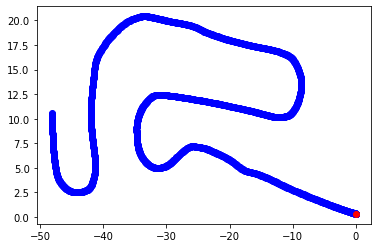

In [17]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])

plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')



## Exporting models

In [9]:
import torch

policy_model = trainer.get_policy().model
policy_model_hiddens = policy_model._hidden_layers
policy_model_logits = policy_model._logits
policy_model_hiddens

Sequential(
  (0): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=142, out_features=300, bias=True)
      (1): Tanh()
    )
  )
  (1): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Tanh()
    )
  )
)

In [10]:
import torch
policy_path = '../checkpoints/race_v2.0.4.pt'
torch.save({
    'h1': policy_model_hiddens[0]._model.state_dict(),
    'h2': policy_model_hiddens[1]._model.state_dict(),
    'logits': policy_model_logits._model.state_dict()
}, policy_path)

In [ ]:
class Policy(torch.nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.h1 = torch.nn.Sequential(
                torch.nn.Linear(in_features=182, out_features=300, bias=True),
                torch.nn.Tanh()
            )
        self.h2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=300, bias=True),
            torch.nn.Tanh()
        )
        
        self.logits =  torch.nn.Sequential(
            torch.nn.Linear(in_features=300, out_features=4, bias=True),
        )
        
    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.logits(x)

exported_policy = Policy()
exported_policy.h1.load_state_dict(torch.load(policy_path)['h1'])
exported_policy.h2.load_state_dict(torch.load(policy_path)['h2'])
exported_policy.logits.load_state_dict(torch.load(policy_path)['logits'])
exported_policy.eval()

In [ ]:
done = False
env = F110RaceEnv({}, test_map_name='Oschersleben1')
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    obs_t = torch.tensor(obs, dtype=torch.float32)
    output = exported_policy(obs_t).detach().numpy()
    v = output[0]
    th = output[1]
#     v = np.clip(v, -1, 1)
#     th = np.clip(th, -1, 1)
    obs, reward, done, info = env.step([v, th])
#     print(obs[-2:])
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    env.render()
print(f'reward:{r}')
env.close()

# hist

## Reward plots

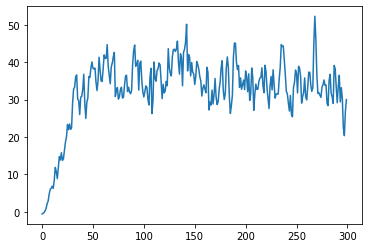

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

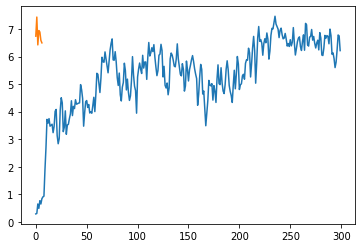

In [26]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/final_destination_r', 'rb') as f:
    rs = pickle.load(f)
    
with open('../checkpoints/phy_v6.2.1_r', 'rb') as f:
    rs2 = pickle.load(f)
    
    
plt.plot(rs)
plt.plot(rs2)

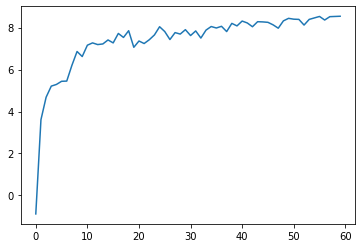

In [24]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/final_destination_er', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
